## Overview ##

1. 19 columns were identified as having NULL values, out of which 4 columns have more than 70 percent were NULL, which were dropped
2. The following attributes were chosen based on our initial correlation analysis; which are some of the common attributest between test datasets 
   LotArea , BldgType,  HouseStyle ,  YearBuilt,    FullBath,   HalfBath ,   BedroomAbvGr
3. Another correlation analysis was performed among the selected attributes to avoid multicollinearity 
4. In order to avoid outliers, LotArea greater than 50,000 sq.ft. were eliminated 
5. Test datasets are gathered from Delaware- Bear, Delaware- Newark, Delaware-Wilmington and the latest data from Iowa- Ames.
6. Full Bath, Half Bath, Year Built and lot area are the most significant predictors in the model
7. With this prediction model, predicted house price  is off by an average of  $53,600
8. The R^2 statistic shows how well the model explains SalePrice.
9. In this model, since R^2 and Adjusted R^2 are close, model is not overfit.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from sklearn import metrics

import cpi
cpi.update()

### Data Set

In [2]:
housingData=pd.read_csv('Data/housing.csv')
housingData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Basic EDA

In [3]:
housingData.shape

(1460, 81)

In [4]:
housingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Attribute Correlation Metrics

In [5]:
corr = housingData.corr()
corr.style.background_gradient()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

### FInd missing Data

In [6]:
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])),ignore_index=True)
    return miss_df

In [7]:
miss_df = find_missing_percent(housingData)
'''Displays columns with missing values'''
display(miss_df[miss_df['PercentMissing']>0.0])
print("\n")

print("Number of columns with missing values:"+(str(miss_df[miss_df['PercentMissing']>0.0].shape[0])))

,ColumnName,TotalMissingVals,PercentMissing
3,LotFrontage,259.0,17.74
6,Alley,1369.0,93.77
25,MasVnrType,8.0,0.55
26,MasVnrArea,8.0,0.55
30,BsmtQual,37.0,2.53
31,BsmtCond,37.0,2.53
32,BsmtExposure,38.0,2.60
33,BsmtFinType1,37.0,2.53
35,BsmtFinType2,38.0,2.60
42,Electrical,1.0,0.07




Number of columns with missing values:19


In [8]:
drop_cols = miss_df[miss_df['PercentMissing'] >70.0].ColumnName.tolist()

print("Number of columns with more than 70%:"+ str(len(drop_cols)))
housingData = housingData.drop(drop_cols,axis=1)
#test = test.drop(drop_cols,axis =1)

miss_df = miss_df[miss_df['ColumnName'].isin(housingData.columns)]
'''Columns to Impute'''
impute_cols = miss_df[miss_df['TotalMissingVals']>0.0].ColumnName.tolist()
miss_df[miss_df['TotalMissingVals']>0.0]

Number of columns with more than 70%:4


,ColumnName,TotalMissingVals,PercentMissing
3,LotFrontage,259.0,17.74
25,MasVnrType,8.0,0.55
26,MasVnrArea,8.0,0.55
30,BsmtQual,37.0,2.53
31,BsmtCond,37.0,2.53
32,BsmtExposure,38.0,2.60
33,BsmtFinType1,37.0,2.53
35,BsmtFinType2,38.0,2.60
42,Electrical,1.0,0.07
57,FireplaceQu,690.0,47.26


### Basic Stats

In [9]:
housingData.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


array([<AxesSubplot:title={'center':'LotArea'}, xlabel='LotArea', ylabel='Frequency'>],
      dtype=object)

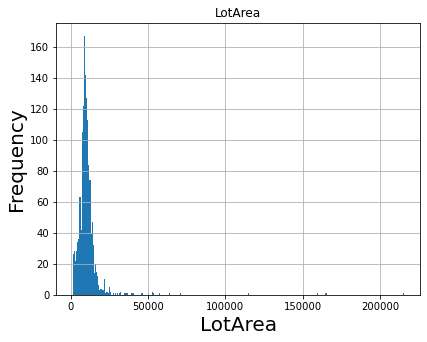

In [10]:
freq1, bin_edges1=np.histogram(housingData.LotArea, bins='fd')

plt.figure(figsize=(15,5))  
ax1 = plt.subplot(1,2,1)
ax1.set_title('LotArea',fontsize=20)
ax1.set_xlabel('LotArea',fontsize=20)
ax1.set_ylabel('Frequency',fontsize=20)
housingData[['LotArea']].hist(bins=bin_edges1,ax = ax1, xlabelsize=10, ylabelsize=10)

### Removing Outlier

In order to avoid outliers, LotArea greater than 50,000 sq.ft. were eliminated 

In [11]:
# Dropping lotArea greater than 50000 to remove outlier 
housingData = housingData[housingData.LotArea <= 50000].copy()
housingData.shape

(1449, 77)

### Adjust for inflation using CPI

In [41]:
housingData['ADJUSTED_SalesPrice'] = housingData.apply(lambda x: cpi.inflate(x.SalePrice, x.YrSold), axis=1)

##### Prepare the data by separating X and y
##### Dropping unimportant features, such as <>
##### Note that interesting features might be engieered from the dropped features above

In [42]:
X=housingData[['LotArea','BldgType','HouseStyle','YearBuilt','FullBath','HalfBath','BedroomAbvGr']].copy()
Y=housingData[['ADJUSTED_SalesPrice']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LotArea       1449 non-null   int64 
 1   BldgType      1449 non-null   object
 2   HouseStyle    1449 non-null   object
 3   YearBuilt     1449 non-null   int64 
 4   FullBath      1449 non-null   int64 
 5   HalfBath      1449 non-null   int64 
 6   BedroomAbvGr  1449 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 90.6+ KB


array([[<AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'FullBath'}>,
        <AxesSubplot:title={'center':'HalfBath'}>],
       [<AxesSubplot:title={'center':'BedroomAbvGr'}>, <AxesSubplot:>]],
      dtype=object)

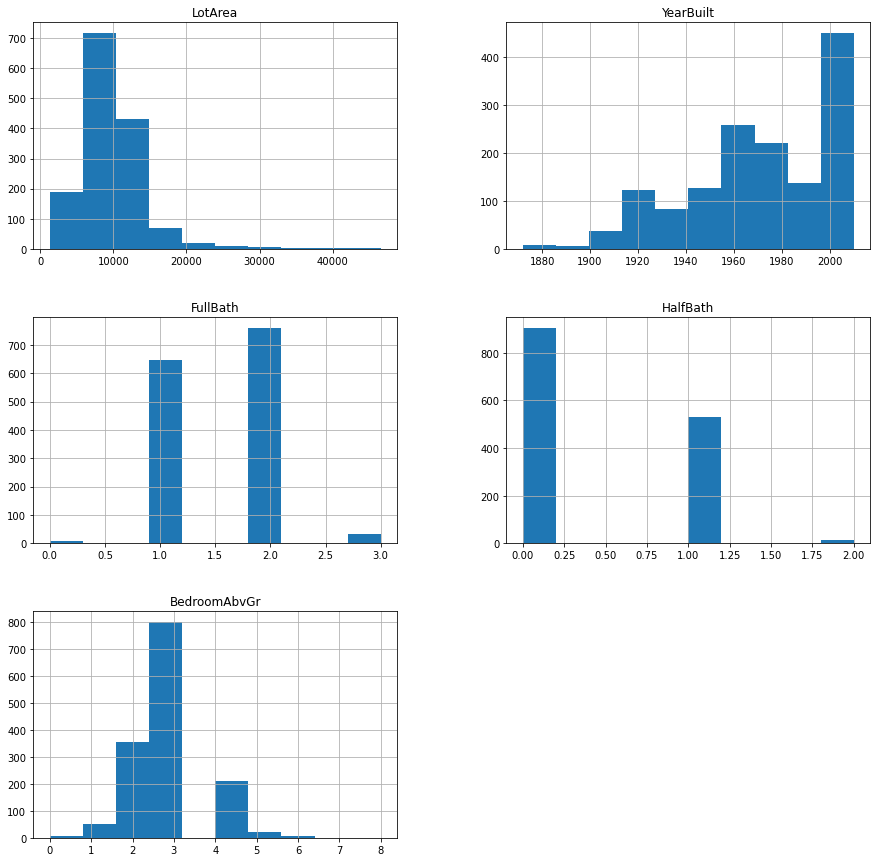

In [13]:
X.hist(figsize=(15,15))

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

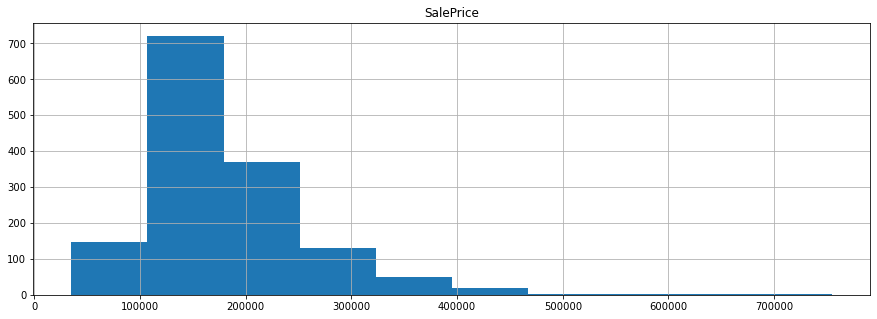

In [14]:
Y.hist(figsize=(15,5))

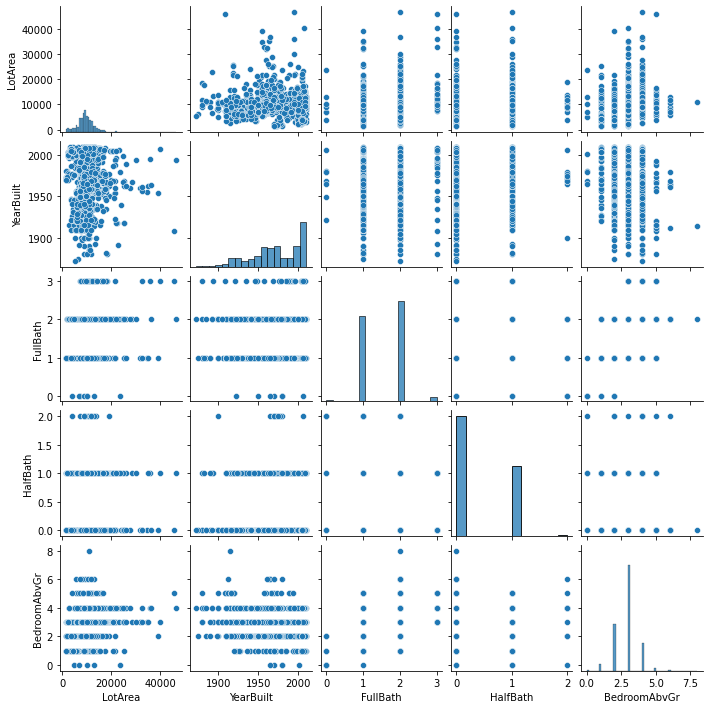

In [15]:
sns.pairplot(X[['LotArea', 'YearBuilt', 'FullBath', 'HalfBath',
       'BedroomAbvGr']], height=2)

### Split the data into train and test

In [16]:
# Split the data into a training set and a test set. 
# Any number for the random_state is fine, see 42: https://en.wikipedia.org/wiki/42_(number) 
# We choose to use 20% (test_size=0.2) of the data set as the test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1159, 7)
(290, 7)
(1159, 1)
(290, 1)


In [17]:
num_features =['LotArea', 'YearBuilt', 'FullBath', 'HalfBath','BedroomAbvGr']
cat_features = ['BldgType','HouseStyle']

## Data pre-processing
We will build a pipeline to do some of the following tasks:

- Missing data
- Feature scaling (important for certain model such as Gradient Descent based models)
- Categorical feature encoding
- Outlier removal
- Transformation
- Custom processing

In [18]:
# any missing values?
X_train.isnull().sum()

LotArea         0
BldgType        0
HouseStyle      0
YearBuilt       0
FullBath        0
HalfBath        0
BedroomAbvGr    0
dtype: int64

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

# Create the preprocessing pipeline for numerical features
# Pipeline(steps=[(name1, transform1), (name2, transform2), ...]) 
# NOTE the step names can be arbitrary

# Step 1 is feature scaling via standardization - making features look like normal-distributed 
# see sandardization: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
num_pipeline = Pipeline(
    steps=[
        #('poly',PolynomialFeatures(degree =2)),  # we will tune differet strategies later
        ('scaler', StandardScaler())
        ]
)

# Create the preprocessing pipelines for the categorical features
# There are two steps in this pipeline:
# Step 1: one hot encoding

cat_pipeline = Pipeline(
    steps=[
                ('onehot', OneHotEncoder())
    ]
)

# Assign features to the pipelines and Combine two pipelines to form the preprocessor
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_features),
        ('cat_pipeline', cat_pipeline, cat_features),
    ]
)

## Model traning, tuning, evaluation and selection

Next, we attach three different models (Linear, Ridge, XGBoost) to the same pre-processing pipeline and tune the some parameters using GridSearch with cross validation. Then, we compare their performance and choose the best model to proceed. 

### Using Linear Regression

In [20]:
# we show how to use GridSearch with K-fold cross validation (K=10) to fine tune the model
# we use the accuracy as the scoring metric with training score return_train_score=True
from sklearn.model_selection import GridSearchCV

# try Linear Regression
from sklearn.linear_model import LinearRegression

# rf pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression()),
])

parameters_lr=[
    {
        'classifier__fit_intercept': [True,False],
        'classifier__copy_X': [True, False],
        'classifier__normalize': [True, False]
    }
]                 

grid_search_lr = GridSearchCV(pipeline_lr,parameters_lr, cv=2)

In [22]:
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'YearBuilt',
                                                                          'FullBath',
                                                                          'HalfBath',
                                                                          'BedroomAbvGr']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('onehot',


In [28]:
# check the best performing parameter combination
grid_search_lr.best_params_

{'classifier__copy_X': True,
 'classifier__fit_intercept': True,
 'classifier__normalize': False}

In [29]:
# build-in CV results keys
sorted(grid_search_lr.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_classifier__copy_X',
 'param_classifier__fit_intercept',
 'param_classifier__normalize',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [43]:
# best linear regression model test score
grid_search_lr.best_score_

0.5158340313554397

### Using Ridge Classifier

In [50]:
from sklearn.linear_model import Ridge

# rf pipeline
pipeline_rg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf_RG', Ridge()),
])

parameters_rg=[
    {
        'clf_RG__alpha': [0,0.2,0.01,1.0],
        'clf_RG__copy_X': [True, False],
        'clf_RG__fit_intercept': [True, False]
    }
]                 

grid_search_rg = GridSearchCV(pipeline_rg,parameters_rg, cv=5)

In [51]:
grid_search_rg.fit(X_train, y_train)

D:\Softwares\anaconda3\envs\MISY631\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3476e-18): result may not be accurate.
  overwrite_a=True).T
D:\Softwares\anaconda3\envs\MISY631\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.46572e-18): result may not be accurate.
  overwrite_a=True).T
D:\Softwares\anaconda3\envs\MISY631\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.70237e-18): result may not be accurate.
  overwrite_a=True).T
D:\Softwares\anaconda3\envs\MISY631\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3476e-18): result may not be accurate.
  overwrite_a=True).T
D:\Softwares\anaconda3\envs\MISY631\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.46572e-18): result may not be accurate.
  overwrite_a=True).T
D:\Soft

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'YearBuilt',
                                                                          'FullBath',
                                                                          'HalfBath',
                                                                          'BedroomAbvGr']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('onehot',


In [52]:
# best linear regression model test score
grid_search_rg.best_score_

0.5168534376233959

In [53]:
# best test score
print('best linear regression score is: ', grid_search_lr.best_score_)
print('best Ridge classifier score is: ', grid_search_rg.best_score_)

best linear regression score is:  0.5158340313554397
best Ridge classifier score is:  0.5168534376233959


In [62]:
# select the best model
# the best parameters are shown, note SimpleImputer() implies that mean strategry is used
clf_best = grid_search_lr.best_estimator_

In [63]:
from sklearn.metrics import accuracy_score

In [65]:
# final test on the testing set
# To predict on new data: simply calling the predict method 
# the full pipeline steps will be applied to the testing set followed by the prediction
y_pred = clf_best.predict(X_test)

# calculate accuracy, Note: y_test is the ground truth for the tesing set
# we have similiar score for the testing set as the cross validation score - good

#print('Accuracy Score :' (accuracy_score(y_test, y_pred)))

In [64]:
#===========   R-square and other metrics ===================
r_square= metrics.r2_score(y_test, y_pred)
mae_y = metrics.mean_absolute_error(y_test, y_pred)
mse_y = metrics.mean_squared_error(y_test, y_pred)
rmse_y = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Linear::r_square={0}::mean_absolute_error={1}::mean_square_error={2}::sqrt_mean_square_error={3}::".format(r_square,mae_y,mse_y,rmse_y))

Linear::r_square=0.5680789999084976::mean_absolute_error=33355.881297038395::mean_square_error=2152750173.939602::sqrt_mean_square_error=46397.73888822172::


## Feature Importance

Given that we are using pipeline and one-hot encoding, the feature importance scores are not very straightforward to get. The following code shows how to get the feature importance scores from the Linear regression and create a plot.

In [30]:
clf_best.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num_pipeline',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['LotArea', 'YearBuilt', 'FullBath',
                                   'HalfBath', 'BedroomAbvGr']),
                                 ('cat_pipeline',
                                  Pipeline(steps=[('onehot', OneHotEncoder())]),
                                  ['BldgType', 'HouseStyle'])]),
 'classifier': LinearRegression()}

In [31]:
clf_best.named_steps['preprocessor']

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['LotArea', 'YearBuilt', 'FullBath',
                                  'HalfBath', 'BedroomAbvGr']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['BldgType', 'HouseStyle'])])

In [78]:
i = clf_best.named_steps['classifier'].coef_
i

array([[ 20595.48593481,  27398.85099593,  28238.94921869,
         11543.01133396,  -2754.22276202,  23702.98387695,
          1464.84686376, -30410.53295122, -13098.94279403,
         18341.64500454,   -628.74728834,    919.86789044,
         -5251.19282405,  25814.33345982,  14759.49900329,
         -6984.73730112,  -9378.18826902, -19250.83467102]])

In [33]:
clf_best['preprocessor'].transformers_

[('num_pipeline',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['LotArea', 'YearBuilt', 'FullBath', 'HalfBath', 'BedroomAbvGr']),
 ('cat_pipeline',
  Pipeline(steps=[('onehot', OneHotEncoder())]),
  ['BldgType', 'HouseStyle'])]

In [34]:
# get columnTransformer
clf_best[0] 

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['LotArea', 'YearBuilt', 'FullBath',
                                  'HalfBath', 'BedroomAbvGr']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['BldgType', 'HouseStyle'])])

In [35]:
clf_best[0].transformers_

[('num_pipeline',
  Pipeline(steps=[('scaler', StandardScaler())]),
  ['LotArea', 'YearBuilt', 'FullBath', 'HalfBath', 'BedroomAbvGr']),
 ('cat_pipeline',
  Pipeline(steps=[('onehot', OneHotEncoder())]),
  ['BldgType', 'HouseStyle'])]

In [36]:
num_original_feature_names = clf_best[0].transformers_[0][2]
num_original_feature_names

['LotArea', 'YearBuilt', 'FullBath', 'HalfBath', 'BedroomAbvGr']

In [37]:
cat_original_feature_names = clf_best[0].transformers_[1][2]
cat_original_feature_names

['BldgType', 'HouseStyle']

In [38]:
cat_new_feature_names = list(clf_best[0].transformers_[1][1]['onehot'].get_feature_names(cat_original_feature_names))
cat_new_feature_names

['BldgType_1Fam',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Fin',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl']

In [39]:
feature_names = num_original_feature_names + cat_new_feature_names
feature_names

['LotArea',
 'YearBuilt',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'BldgType_1Fam',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Fin',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl']

In [66]:
r = pd.DataFrame(i, index=feature_names, columns=['importance'])
r

ValueError: Shape of passed values is (1, 18), indices imply (18, 1)

In [ ]:
r.sort_values('importance', ascending=False)

In [ ]:
r.sort_values('importance', ascending=False).plot.bar()

## Remove unimportant Features

## Persists the model

In [67]:
# Save the model as a pickle file
import joblib
joblib.dump(clf_best, "clf-best.pickle")

['clf-best.pickle']

In [68]:
# Load the model from a pickle file
saved_linear_clf = joblib.load("clf-best.pickle")
saved_linear_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'YearBuilt',
                                                   'FullBath', 'HalfBath',
                                                   'BedroomAbvGr']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['BldgType',
                                                   'HouseStyle'])])),
                ('classifier', LinearRegression())])

In [70]:
#Load Test Data
testhousingData=pd.read_csv('Data/test.csv')
testhousingData.head()

testhousingData.head()
testhousingData_df=testhousingData[['LotArea','BldgType','HouseStyle','YearBuilt','FullBath','HalfBath','BedroomAbvGr']].copy() #,'

In [71]:
pred1 = saved_linear_clf.predict(testhousingData_df)

In [72]:
pred1

array([[149124.96604395],
       [177844.70760263],
       [260836.05384084],
       ...,
       [178355.7849242 ],
       [164435.24891678],
       [238652.98620523]])

## Test Datasets

In [73]:
newark_df=pd.read_csv('Data/Delaware - Newark.csv')
newark_df.head()

,primary_photo/href,last_update_date,source/plan_id,source/agents/0/office_name,source/agents/1/office_name,source/spec_id,source/type,tags/0,tags/1,tags/2,...,photos/3/tags/2/label,photos/3/tags/2/probability,photos/3/href,photos/4/tags/0/label,photos/4/tags/0/probability,photos/4/tags/1/label,photos/4/tags/1/probability,photos/4/tags/2/label,photos/4/tags/2/probability,photos/4/href
0,https://ap.rdcpix.com/baddc47272800901657f4a06...,2021-06-25T11:29:53Z,None,None,None,None,mls,central_air,community_golf,community_outdoor_space,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://ap.rdcpix.com/44d18cc63f349422e7936ad1...,2021-06-26T00:06:47Z,None,None,None,None,mls,central_air,community_outdoor_space,laundry_room,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://ap.rdcpix.com/c130c8a7a13ab8a7ed66bee6...,2021-06-25T16:13:49Z,None,None,BHHS Fox & Roach-Greenville,None,mls,central_air,community_outdoor_space,den_or_office,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://ap.rdcpix.com/b53f18f0fa366b3cad7030f5...,2021-06-25T15:54:48Z,None,Patterson-Schwartz-Newark,None,None,mls,central_air,community_clubhouse,community_elevator,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://ap.rdcpix.com/0b1916875cead776686ee306...,2021-06-25T13:33:26Z,None,RE/MAX Associates-Hockessin,None,None,mls,central_air,community_outdoor_space,cul_de_sac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
bear_df=pd.read_csv('Data/Delaware - Bear.csv')
bear_df.head()

,primary_photo/href,last_update_date,source/plan_id,source/agents/0/office_name,source/agents/1/office_name,source/spec_id,source/type,tags/0,tags/1,tags/2,...,photos/4/tags/2/label,photos/4/tags/2/probability,photos/4/href,photos/1/tags,photos/2/tags,photos/3/tags,photos/4/tags,photos/0/tags,location/address/coordinate,location/county
0,https://ap.rdcpix.com/17d579e0422ad6eddad32cf8...,2021-06-26T00:07:05Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,community_park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://ap.rdcpix.com/c5203540df21e416faf521fd...,2021-06-24T00:02:04Z,NaN,Concord Realty Group,NaN,NaN,mls,central_air,community_outdoor_space,den_or_office,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://ap.rdcpix.com/40510892f3ac918357a54a33...,2021-06-21T12:52:11Z,NaN,Patterson-Schwartz-Hockessin,NaN,NaN,mls,central_air,community_clubhouse,community_outdoor_space,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://ap.rdcpix.com/1309648972d5426a39b8b0b2...,2021-06-22T15:20:06Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,cul_de_sac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://ap.rdcpix.com/455c360f8cdcc6eed32837ad...,2021-06-22T00:02:32Z,NaN,"Long & Foster Real Estate, Inc.",NaN,NaN,mls,central_air,community_outdoor_space,dining_room,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
wilmigton_df=pd.read_csv('Data/Delaware - Wilmington.csv')
wilmigton_df.head()

,primary_photo/href,last_update_date,source/plan_id,source/agents/0/office_name,source/agents/1/office_name,source/spec_id,source/type,tags/0,tags/1,tags/2,...,photos/0/tags,tags/26,primary_photo,photos,tags/27,tags/28,tags/29,tags/30,tags/31,tags/32
0,https://ap.rdcpix.com/23cc467793d4bfedb6feccb5...,2021-06-25T18:02:00Z,NaN,"EXP Realty, LLC",NaN,NaN,mls,central_air,community_outdoor_space,den_or_office,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://ap.rdcpix.com/c707363615d68117a8636f80...,2021-06-25T18:22:21Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,recreation_facilities,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://ap.rdcpix.com/ba0f521b142df98f24d612e5...,2021-06-25T14:30:15Z,NaN,NaN,NaN,NaN,mls,corner_lot,recreation_facilities,basement,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://ap.rdcpix.com/e826dda3d01f6475a845db79...,2021-06-26T00:04:32Z,NaN,Coldwell Banker Realty,NaN,NaN,mls,central_air,community_outdoor_space,forced_air,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://ap.rdcpix.com/f424d73b1a395302dace4b9d...,2021-06-26T00:07:09Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,corner_lot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
ames_df=pd.read_csv('Data/IA - Ames.csv')
ames_df.head()

,primary_photo/href,last_update_date,source/plan_id,source/agents/0/office_name,source/agents/1/office_name,source/spec_id,source/type,tags/0,tags/1,tags/2,...,other_listings/rdc/14/listing_id,other_listings/rdc/14/listing_key,other_listings/rdc/14/status,other_listings/rdc/14/primary,other_listings/rdc/15/listing_id,other_listings/rdc/15/listing_key,other_listings/rdc/15/status,other_listings/rdc/15/primary,tags,products
0,https://ap.rdcpix.com/2e86200c4b34bb90707cffdd...,2021-06-25T13:32:56Z,NaN,CENTURY 21 SIGNATURE-Ames,NaN,NaN,mls,central_air,community_outdoor_space,den_or_office,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://ap.rdcpix.com/739ec9668785c076093ae3ff...,2021-06-23T15:51:31Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,dishwasher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://ap.rdcpix.com/d1f50de0060b11c52eabdeef...,2021-06-25T13:09:27Z,NaN,Hunziker & Assoc.-Ames,Hunziker & Assoc.-Ames,NaN,mls,central_air,community_outdoor_space,dishwasher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://ap.rdcpix.com/e99b2704465c3ef188bc34e6...,2021-06-21T14:39:48Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,dishwasher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://ap.rdcpix.com/2af2e6ff416bd9137b3824bf...,2021-06-22T12:57:52Z,NaN,NaN,NaN,NaN,mls,central_air,community_outdoor_space,dishwasher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
